<a href="https://colab.research.google.com/github/ningjingzhiyuan507/AnalysisTool/blob/master/d2l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 配置GPU版本pytorch

In [ ]:
# 不运行以下代码，总是在import d2l中出错
#!pip install timm==0.4.12
!pip install torch==1.8.1
!pip install torchvision==0.9.1

     |████████████████████████████████| 804.1 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible.


     |████████████████████████████████| 17.4 MB 26.5 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


In [ ]:
!pip install d2l==0.17.3

     |████████████████████████████████| 82 kB 569 kB/s 
     |████████████████████████████████| 9.9 MB 23.6 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 61 kB 7.8 MB/s 
     |████████████████████████████████| 11.6 MB 16.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
!pip install matplotlib==3.0.0

     |████████████████████████████████| 12.8 MB 4.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# 测试GPU
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
!nvidia-smi

Mon May 16 06:51:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.device_count()  # 仅有一个GPU

1

In [ ]:
X = torch.rand(2, 3, device='cuda:0')

In [ ]:
X

tensor([[0.5041, 0.4009, 0.8702],
        [0.5575, 0.4337, 0.0781]], device='cuda:0')

# LeNet-5

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [ ]:
batchSize = 256
trainIter, testIter = d2l.load_data_fashion_mnist(batch_size=batchSize)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def evaluateAccuracyGpu(net, dataIter, device=None):
  """使用GPU计算模型在数据集上的精度"""
  if isinstance(net, nn.Module):
    net.eval()  # 设置为评估模式
    if not device:
      device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
      for X, y in dataIter:
        if isinstance(X, list):
          X = [x.to(device) for x in X]
        else:
          X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, trainIter, testIter, numEpochs, lr, device):
  """用GPU训练模型"""
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)  # 使用Xavier随机初始化模型参数
  net.apply(init_weights)
  print("training on", device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, numEpochs], legend=['train loss', 'train acc', 'test acc'])
  timer, numBatches = d2l.Timer(), len(trainIter)
  for epoch in range(numEpochs):
    # 训练损失之和，训练准确率之和，样本数
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(trainIter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      yHat = net(X)
      l = loss(yHat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(yHat, y), X.shape[0])
      timer.stop()
      trainL = metric[0] / metric[2]
      trainAcc = metric[1] / metric[2]
      if (i+1) % (numBatches // 5) == 0 or i == numBatches - 1:
        animator.add(epoch + (i+1) / numBatches, (trainL, trainAcc, None))
    testAcc = evaluateAccuracyGpu(net, testIter)
    animator.add(epoch + 1, (None, None, testIter))
  print(f'loss {trainL: .3f}, train acc {trainAcc:.3f},'
        f'test acc {testAcc:.3f}')
  print(f'{metric[2] * numEpochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

TypeError: ignored

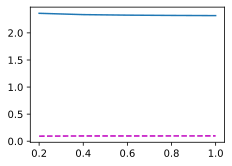

In [ ]:
lr, numEpochs = 0.9, 10
train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

loss 0.494, train acc 0.812, test acc 0.783
24635.0 examples/sec on cuda


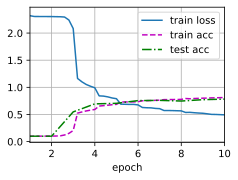

In [ ]:
d2l.train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

# 现代卷积神经网络

## AlexNet

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    # 这里我们使用一个11*11的更大窗口来捕捉对象（image图像比LeNet使用的图像都要大10倍以上）
    # 同时，步幅为4以减少输出的高度和宽度
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用padding为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，pooling不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10
    nn.Linear(4096, 10)
)

In [ ]:
batchSize = 128
trainIter, testIter = d2l.load_data_fashion_mnist(batchSize, resize=224)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.328, train acc 0.880, test acc 0.883
1411.3 examples/sec on cuda


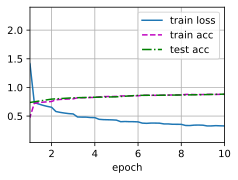

In [ ]:
lr, numEpochs = 0.01, 10
d2l.train_ch6(net, trainIter, testIter, numEpochs, lr, 'cuda')

## VGG

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    )
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  # 卷积层部分
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels

  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      # 全连接层部分
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 10)
  )

In [ ]:
net = vgg(conv_arch)

In [ ]:
# 测试
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# 训练模型
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

KeyboardInterrupt: ignored

ImportError: ignored

<Figure size 252x180 with 1 Axes>

## NiN

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
  )

In [ ]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数量是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    # 将四维的输出转化成二维的输出，其形状为（批量大小，10）
    nn.Flatten()
)

In [ ]:
# 测试
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.792, train acc 0.734, test acc 0.754
1046.7 examples/sec on cuda


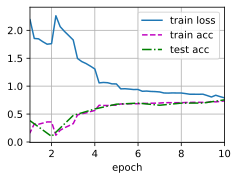

In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

## GoogLeNet

In [ ]:
from torch.nn import functional as F

In [ ]:
class Inception(nn.Module):
  # c1-c4是每条路径的输出通道数
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
      super(Inception, self).__init__(**kwargs)
      # 线路1，单1×1卷积层
      self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
      # 线路2，1*1卷积层后接3*3卷积层
      self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
      self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
      # 线路3，1*1卷积层后接5*5卷积层
      self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
      self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
      # 线路4，3*3最大汇聚层后接1*1卷积层
      self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
      self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self, x):
      p1 = F.relu(self.p1_1(x))
      p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
      p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
      p4 = F.relu(self.p4_2(self.p4_1(x)))
      # 在通道维度上联结输出
      return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
  )

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
# 测试
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.258, train acc 0.902, test acc 0.890
1355.9 examples/sec on cuda


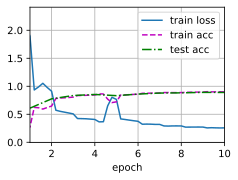

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

## 批量规范化

### 从零实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
  if not torch.is_grad_enabled():
    # 如果是在预测模式下，直接使用传入的移动平均得到的均值和方差
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      # 使用全连接层的情况，计算特征维上的均值和方差
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差
      # 这里我们需要保持X的shape，以便于后面做广播运算
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    # 训练模式下，用当前的均值和方差做标准化
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta  # 缩放和移位
  return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
  # num_features: 完全连接层的输出数量或卷积层的输出通道数
  # num_dims: 2表示完全连接层，4表示卷积层
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    # 非模型参数的变量初始化成0和1
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # 保存更新过的moving_mean和moving_var
    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
    )
    return Y

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.270, train acc 0.901, test acc 0.844
9078.8 examples/sec on cuda


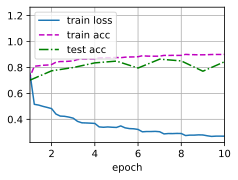

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

In [ ]:
# 查看第一个批量规范化层训练出的拉伸参数gamma和偏移参数beta
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1,))

(tensor([2.8275, 4.0946, 2.8114, 0.2814, 1.4243, 3.3104], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.2636, -2.4335, -2.9745, -0.1787,  1.3267,  2.7043], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

### 简明实现

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.260, train acc 0.904, test acc 0.878
16382.1 examples/sec on cuda


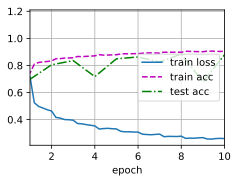

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, 'cuda')

# 计算机视觉

## 图像增广

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
# 加载CIFAR-10数据集，共50W个图片
all_images = torchvision.datasets.CIFAR10(train=True, root='../data', download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34b5a20d10>,
      dtype=object)

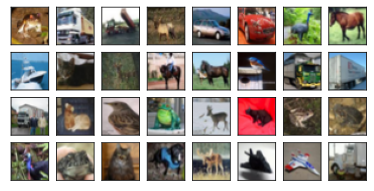

In [ ]:
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [ ]:
train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ]
)
test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [ ]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../data', train=is_train, transform=augs, download=True
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers()
    )
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多CPU进行小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc']
    )
    # net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net = net.to(devices[0])  # 当cpu和gpu同时存在时要明确指明计算位置
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr = 0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.177, train acc 0.938, test acc 0.785
352.7 examples/sec on [device(type='cuda', index=0)]


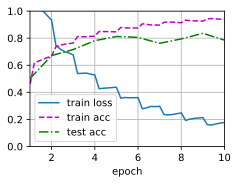

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

## 微调(迁移学习)

In [ ]:
import os

In [ ]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [ ]:
# 读取图像文件
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34b0541ad0>,
      dtype=object)

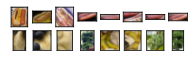

In [ ]:
# 正负样本展示
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs, 2, 8, scale=0.4)

In [ ]:
# 通道标准化
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# 图像缩放和增广
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [ ]:
# 以ResNet-18为源模型
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Parameter containing:
tensor([[ 0.0922, -0.0671, -0.0683,  ...,  0.0695,  0.0001,  0.0108],
        [ 0.0180,  0.0694,  0.0484,  ..., -0.1023, -0.0687, -0.0311]],
       requires_grad=True)

In [ ]:
# 微调模型
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
  train_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(
          os.path.join(data_dir, 'train'), transform=train_augs
      ),
      batch_size=batch_size, shuffle=True
  )
  test_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(
          os.path.join(data_dir, 'test'), transform=test_augs
      ),
      batch_size=batch_size
  )
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction='none')
  if param_group:
    params_lx = [param for name, param in net.named_parameters() if name not in ['fc.weight', 'fc.bias']]
    trainer = torch.optim.SGD([
        {'params': params_lx},
        {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
        lr=learning_rate, weight_decay=0.001
      )
  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
  
  d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.146, train acc 0.944, test acc 0.939
178.2 examples/sec on [device(type='cuda', index=0)]


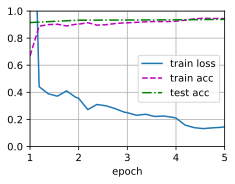

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

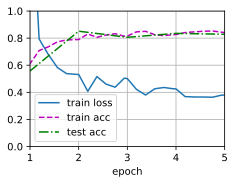

In [ ]:
# 重新训练模型
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)